In [3]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift, estimate_bandwidth
from shapely.geometry import Polygon
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

#### DEFINE VARIABLES

In [4]:
PATH = 'data/radar/'
DAY = sorted(os.listdir(PATH))[0]

#### READ FIRST FILES TO LOAD GLOBAL VARIABLES

In [5]:
first_file = PATH+str(DAY)+'/'+str(sorted(os.listdir(PATH+str(DAY)))[0])
try:
    xds = xr.open_dataset(first_file)   
except Exception as e:
    print('File not found')
    
RUNIT = xds.rain_rate.units
RKM = xds.rain_rate.height_km
LON = xds.lon0.data                 ### Coordinate Longitude Matrix
LAT = xds.lat0.data                 ### Corrdinate Latitude Matrix
X0 = xds.x0                         ### Matrix of points
Y0 = xds.y0
RADAR = (np.median(LON),np.median(LAT))

#### READ TIMES

In [6]:
def read_data(date):
    
    path = 'data/radar/'
    dataset = []
    interval = len(os.listdir(path+str(date)))    
    
    # Original grid dimensions
    nx = 241
    ny = 241

    # Define container
    frames = np.zeros( (interval, nx, ny ) )    
    
    for i in range(interval):
        d = str(path)+str(date)+'/'
        file = (sorted(os.listdir(path+str(date)))[i])
        xds = xr.open_dataset(d+file)
        rr = xds.rain_rate
        frames[i] =  rr
            
    return frames

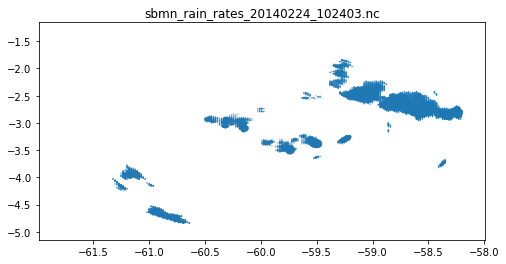

In [7]:
DAY = 20140224
figtime = 0
frames = read_data(DAY)

filename = sorted(os.listdir(PATH+str(DAY)))[figtime]
plt.figure(figsize=(8,4))
plt.title(filename)
plt.scatter(LON,LAT,frames[figtime])
plt.show();

In [140]:
def pre_processing(time):
    np.warnings.filterwarnings('ignore')
    
    ## thereshold value to track  2.85
    threshold = 9.96
    
    rs =  (np.where(time != np.nan) and np.where(time > threshold))
    rs = np.asanyarray(rs)
    pe = pd.DataFrame({'x1':rs[0],'y1':rs[1]})
        
    return pe

In [141]:
def clusterization(time):
    te = time
    
    if len(te) < 10:
        return None
    
    bandwidth = estimate_bandwidth(te, quantile=0.1, n_samples=None, random_state=0, n_jobs=None)
    
    if bandwidth > 0:
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=None, cluster_all=True, min_bin_freq=1,
    n_jobs=None, seeds=None)
    else:
        ms = MeanShift(bandwidth=10, bin_seeding=None, cluster_all=True, min_bin_freq=1,
    n_jobs=None, seeds=None)

    ms.fit(te)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    te['cluster']=labels
    
    return te

In [142]:
def create_data(day,time,frames,clusters):
    
    data = pd.DataFrame(columns=['DATETIME', 'N_CLUSTER','ID_CLUST','LON','LAT','R_FALL','DBZ'])

    # get values datetime
    dtime = xr.open_dataset(str(PATH)+str(day)+'/'+str(sorted(os.listdir(PATH+str(day)))[time])).start_time.values
    
    lat = (LAT[clusters['x1'],clusters['y1']])
    lon = (LON[clusters['x1'],clusters['y1']])
    
    # get values from RAIN_FALL
    rfall = (frames[clusters['x1'],clusters['y1']])
    
    data['LON'] = lon
    data['LAT'] = lat
    data['N_CLUSTER'] = len(clusters['cluster'].unique())
    data['ID_CLUST'] = clusters['cluster']
    data['R_FALL'] = rfall
    data['DBZ'] = 10 * np.log10(200*data['R_FALL']**1.6)
    data['DATETIME'] = pd.to_datetime(dtime)
    data = data.set_index('DATETIME')
    
    # get 5 largest values from DBZ
    largest = 3
    cdata = pd.DataFrame()
    for i in range(data['N_CLUSTER'].max()):
        ct = data.loc[data['ID_CLUST'] == i]
        ct = ct.nlargest(largest,'DBZ')
        cdata = cdata.append(ct)
            
    tdata = pd.DataFrame()
    for i in range(cdata['N_CLUSTER'].max()):
        if len(cdata.loc[cdata['ID_CLUST'] == i]) >= 3:
            tdata = tdata.append((cdata.loc[cdata['ID_CLUST'] == i]))
            
    tdata['N_CLUSTER'] = len(tdata['ID_CLUST'].unique())
    
    del data,dtime,lat,lon,rfall,largest,cdata,ct
    
    return tdata

In [143]:
day = DAY
time = 15
frames = read_data(day)
clusters = clusterization(pre_processing(frames[time]))

In [145]:
data = create_data(day,time,frames[time],clusters)
data.head()

,N_CLUSTER,ID_CLUST,LON,LAT,R_FALL,DBZ
DATETIME,,,,,,
2014-02-24 13:24:05,10,0,-59.848209,-1.837751,21.620676,44.368208
2014-02-24 13:24:05,10,0,-60.009975,-1.819793,20.265070,43.918270
2014-02-24 13:24:05,10,0,-59.992001,-1.819793,19.644730,43.702237
2014-02-24 13:24:05,10,1,-60.027954,-2.053355,26.223869,45.709448
2014-02-24 13:24:05,10,1,-60.135826,-2.143178,24.718960,45.298783


In [146]:
from shapely import wkt
def geo_data(cdata):
 
    cdata['geometry'] = list(zip(cdata.LON,cdata.LAT))
    cdata.geometry = cdata.geometry.apply(Point)
    cdata['geometry'] = cdata['geometry'].apply(lambda x: x.coords[0])
    cdata = cdata.groupby('ID_CLUST')['geometry'].apply(lambda x: Polygon(x.tolist())).reset_index()
    cdata = gpd.GeoDataFrame(cdata, geometry = 'geometry')
    cdata.crs = {'init' :'epsg:4326'}
    return cdata
geo_data(data).geometry.convex_hull.to_file('shapefiles/centroids.shp')
geo_data(data)

,ID_CLUST,geometry
0,0,POLYGON ((-59.84820938110352 -1.83775126934051...
1,1,POLYGON ((-60.0279541015625 -2.053354978561401...
2,2,POLYGON ((-59.4342041015625 -3.149151086807251...
3,3,POLYGON ((-59.79406356811523 -3.20318007469177...
4,4,POLYGON ((-60.31569671630859 -2.50246644020080...
5,5,POLYGON ((-60.15392303466797 -3.02352356910705...
6,6,POLYGON ((-59.20007705688477 -3.41848611831665...
7,7,POLYGON ((-59.05646514892578 -3.00515699386596...
8,8,POLYGON ((-58.82277679443359 -2.82527446746826...
9,9,POLYGON ((-59.27248764038086 -2.80770134925842...


In [147]:
data['geometry'] = list(zip(data.LON,data.LAT))
data.geometry = data.geometry.apply(Point)
gdata = gpd.GeoDataFrame(data,geometry='geometry')
gdata.crs = {'init' :'epsg:4326'}
gdata.to_file('shapefiles/points.shp')
gdata.head()

,N_CLUSTER,ID_CLUST,LON,LAT,R_FALL,DBZ,geometry
DATETIME,,,,,,,
2014-02-24 13:24:05,10,0,-59.848209,-1.837751,21.620676,44.368208,POINT (-59.84820938110352 -1.837751269340515)
2014-02-24 13:24:05,10,0,-60.009975,-1.819793,20.265070,43.918270,POINT (-60.00997543334961 -1.819793343544006)
2014-02-24 13:24:05,10,0,-59.992001,-1.819793,19.644730,43.702237,POINT (-59.99200057983398 -1.819793462753296)
2014-02-24 13:24:05,10,1,-60.027954,-2.053355,26.223869,45.709448,POINT (-60.0279541015625 -2.053354978561401)
2014-02-24 13:24:05,10,1,-60.135826,-2.143178,24.718960,45.298783,POINT (-60.13582611083984 -2.143178224563599)


### CREATE TIFF FILE

In [69]:
#!/usr/bin/env python
from osgeo import gdal
from osgeo import osr
import numpy as np
import os, sys

#  Initialize the Image Size
image_size = (241,241)

lat = [-5.348556,-0.948556]
lon = [-62.192,-57.7919999]
            
# set geotransform
nx = image_size[0]
ny = image_size[1]
xmin, ymin, xmax, ymax = [min(lon), max(lat), max(lon), min(lat)]
xres = (xmax - xmin) / float(nx)
yres = (ymax - ymin) / float(ny)
geotransform = (xmin, xres, 0, ymax, 0, -yres)

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create('tiff/myGeoTIFF.tif', ny, nx, 1, gdal.GDT_Byte)

dst_ds.SetGeoTransform(geotransform)    # specify coords
srs = osr.SpatialReference()            # establish encoding
srs.ImportFromEPSG(4326)                # WGS84 lat/long
dst_ds.SetProjection(srs.ExportToWkt()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(frames[time])   # write b-band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None